# RT-PINNs:
### Physics-Informed Neural Network for Compressible Turbulent Mixing
**Project:** MAE557 Final Project  
**Description:** A mesh-free solver for the 2D Rayleigh-Taylor Instability using Deep Learning.

This notebook implements a PINN to solve the compressible Euler/Navier-Stokes equations. It defines the neural network architecture, the physics-based loss functions (PDE residuals), and the training loops required to minimize these residuals.

## 1. Environment Setup
Importing necessary libraries (`torch`, `matplotlib`, `numpy`) and configuring the computing device.
* **Note:** This script will automatically utilize a GPU (`cuda`) if available. Using a GPU is highly recommended for training runs exceeding 10,000 epochs.

In [ ]:
!conda install pytorch torchvision torchaudio cpuonly -c pytorch

In [1]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.5.1
CUDA available: False


## 2. PINN Architecture
Define the Deep Feed-Forward Neural Network.
* **Inputs:** Spatio-temporal coordinates $(t, x, y)$.
* **Outputs:** Primitive flow variables $(\ln \rho, u, v, \ln p, Y_h)$.
* **Activation:** `tanh` is used for its smooth gradients.
* **Positivity Enforcement:** Predict log-density and log-pressure to ensure physical positivity after transformation.

In [2]:
import torch
import torch.nn as nn
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt
from matplotlib import style
import time
import os
from tqdm import tqdm

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the Neural Network
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.activation = nn.Tanh()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))

    def forward(self, t, x, y):
        inputs = torch.cat([t, x, y], axis=1)
        for i, layer in enumerate(self.layers):
            inputs = layer(inputs)
            if i < len(self.layers) - 1:
                inputs = self.activation(inputs)
        # Network predicts the 5 primary variables
        # rho, u, v, p, Yh
        # Predicting primitives can sometimes be more stable than conserved variables
        return inputs


Using device: cpu


## 3. Physics & Loss Calculation
This section encodes the governing equations into the loss function.
* **Automatic Differentiation:** Use `torch.autograd` to compute exact derivatives ($\partial u / \partial x$, etc.) with respect to the inputs.
* **Equations:** The residuals for Mass, Momentum (x/y), Energy, and Species conservation are calculated.

## 4. Training Loop (Inviscid)
The optimization loop for the Euler equations ($\mathrm{Re} = \infty$).
* **Sampling:** Collocation points are generated using Latin Hypercube Sampling and resampled periodically to prevent overfitting.
* **Loss Weighting:** Weights for IC, BC, and PDE losses are adjusted to balance the training (e.g., prioritizing boundary conditions early on).
* **Logging:** Loss history is saved to `training_log.csv`.

In [7]:
# Main training script
if __name__ == '__main__':
    # --- Physical and Domain Parameters matching pyranda script ---
    gx = -0.01
    mwH = 3.0
    mwL = 1.0
    Runiv = 1.0
    CVh, CPh = 1.0, 1.4
    CVl, CPl = 1.0, 1.4
    p0 = 1.0
    T0 = 1.0
    
    # Domain
    t_min, t_max = 0.0, 100.0
    x_min, x_max = 0.0, 2.8 * np.pi
    y_min, y_max = 0.0, 2.0 * np.pi
    Npts = 256
    
    # --- Network, Training, and Loss Weighting Setup ---
    # Input: 3 (t,x,y), Output: 5 (rho, u, v, p, Yh)
    layers = [3] + [128] * 8 + [5]
    pinn = PINN(layers).to(device)

    optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.9)
    
    # Loss weights, for the first 10000 epochs, w_pde = 1.0, w_ic,w_bc = 100.0
    w_pde = 10.0
    w_ic = 10.0
    w_bc = 10.0
    
    # --- Generate Training Points (Collocation Points) ---
    N_pde = 25000
    N_ic = 10000
    N_bc = 7500
    num_epochs = 100000    
      
    # For PDE Loss
    sampler = qmc.LatinHypercube(d=3, seed=123)
    pde_sample = sampler.random(n=N_pde)
    t_pde = torch.tensor(t_min + (t_max - t_min) * pde_sample[:, 0], dtype=torch.float32).view(-1, 1).to(device)
    x_pde = torch.tensor(x_min + (x_max - x_min) * pde_sample[:, 1], dtype=torch.float32).view(-1, 1).to(device)
    y_pde = torch.tensor(y_min + (y_max - y_min) * pde_sample[:, 2], dtype=torch.float32).view(-1, 1).to(device)
    
    # For Initial Condition Loss
    ic_sampler = qmc.LatinHypercube(d=2, seed=456)
    ic_sample = ic_sampler.random(n=N_ic)
    x_ic = torch.tensor(x_min + (x_max - x_min) * ic_sample[:, 0], dtype=torch.float32).view(-1, 1).to(device)
    y_ic = torch.tensor(y_min + (y_max - y_min) * ic_sample[:, 1], dtype=torch.float32).view(-1, 1).to(device)
    t_ic = torch.zeros_like(x_ic).to(device)
    
    # For Boundary Condition Loss
    bc_sampler = qmc.LatinHypercube(d=2, seed=789)
    bc_sample = bc_sampler.random(n=N_bc)
    t_bc = torch.tensor(t_min + (t_max - t_min) * bc_sample[:, 0], dtype=torch.float32).view(-1, 1).to(device)
    # Points for x-walls
    y_bc_x_walls = torch.tensor(y_min + (y_max - y_min) * bc_sample[:, 1], dtype=torch.float32).view(-1, 1).to(device)
    # Points for y-periodic
    x_bc_y_periodic = torch.tensor(x_min + (x_max - x_min) * bc_sample[:, 1], dtype=torch.float32).view(-1, 1).to(device)

    # --- Define Initial Conditions ---
    delta_interface = 2.8 * np.pi / Npts * 2.0
    offset_ic = 1.4 * np.pi + 0.5 * torch.sin(4 * y_ic)
    Yh_ic_true = 0.5 * (1.0 + torch.tanh((x_ic - offset_ic) / delta_interface))
    
    R_h = Runiv / mwH
    R_l = Runiv / mwL
    A = gx * (R_h + R_l) / (2.0 * T0 * R_l * R_h)
    B = gx * delta_interface * (R_l - R_h) / (2.0 * T0 * R_l * R_h)
    p_ic_true = p0 * torch.exp(A * (x_ic-offset_ic)) * (torch.cosh((x_ic-offset_ic)/delta_interface))**B
    
    R_ic = R_h * Yh_ic_true + R_l * (1.0 - Yh_ic_true)
    rho_ic_true = p_ic_true / (R_ic * T0)
    u_ic_true = torch.zeros_like(x_ic)
    v_ic_true = torch.zeros_like(x_ic)

    # --- Progress Bar and Logging Setup ---
    # Create directory for checkpoints
    checkpoint_dir = 'checkpoints'
    os.makedirs(checkpoint_dir, exist_ok=True)
    log_file_path = 'training_log.csv'
    
    # --- Logic to Open Log File for Appending ---
    # Check if the log file already exists.
    file_exists = os.path.exists(log_file_path)
    
    # Open the file in 'append' mode ('a'). This will create the file if it doesn't exist.
    log_file = open(log_file_path, 'a')
    
    # If the file did not exist before, it means this is a fresh run.
    # So write the header row.
    if not file_exists:
        log_file.write('Epoch,Total_Loss,PDE_Loss,IC_Loss,BC_Loss,Elapsed_Time\n')
    
    best_loss = float('inf')
    
    # Wrap the training loop with tqdm
    pbar = tqdm(range(start_epoch, num_epochs), desc=f"Training (Resumed from {start_epoch})")
 
    # --- Training Loop ---
    start_time = time.time()
    for epoch in pbar:
        # Resample points every 1000 epochs
        if epoch % 1000 == 0:
            pde_sample = sampler.random(n=N_pde)
            t_pde = torch.tensor(t_min + (t_max - t_min) * pde_sample[:, 0], dtype=torch.float32).view(-1, 1).to(device)
            x_pde = torch.tensor(x_min + (x_max - x_min) * pde_sample[:, 1], dtype=torch.float32).view(-1, 1).to(device)
            y_pde = torch.tensor(y_min + (y_max - y_min) * pde_sample[:, 2], dtype=torch.float32).view(-1, 1).to(device)
    
        optimizer.zero_grad()
        
        # --- FULL PDE LOSS CALCULATION ---
        t_pde.requires_grad = True
        x_pde.requires_grad = True
        y_pde.requires_grad = True

        # Get latent variables from the network
        # The network now predicts (log_rho, u, v, log_p, Yh)
        latent_rho, u, v, latent_p, Yh = torch.split(pinn(t_pde, x_pde, y_pde), 1, dim=1)
        
        # --- Transform outputs to enforce positivity ---
        rho = torch.exp(latent_rho)
        p = torch.exp(latent_p)
        Yh = torch.sigmoid(Yh) # This enforces Yh between 0 and 1
        Yl = 1.0 - Yh
     
        # Calculate conserved and other variables
        rhou = rho * u
        rhov = rho * v
        rhoYh = rho * Yh
        R = (Runiv / mwH) * Yh + (Runiv / mwL) * Yl
        T = p / (rho * R + 1e-8)
        cp = CPh * Yh + CPl * Yl
        cv = CVh * Yh + CVl * Yl
        gamma = cp / (cv + 1e-8)
        Et = p / (gamma - 1.0 + 1e-8) + 0.5 * rho * (u**2 + v**2)
        
        # 3. Calculate all required derivatives for the 5 conservation laws
        # Mass: d(rho)/dt + d(rhou)/dx + d(rhov)/dy = 0
        rho_t = torch.autograd.grad(rho, t_pde, torch.ones_like(rho), create_graph=True)[0]
        rhou_x = torch.autograd.grad(rhou, x_pde, torch.ones_like(rhou), create_graph=True)[0]
        rhov_y = torch.autograd.grad(rhov, y_pde, torch.ones_like(rhov), create_graph=True)[0]
        f_mass = rho_t + rhou_x + rhov_y
        
        # Species: d(rhoYh)/dt + d(rhoYh*u)/dx + d(rhoYh*v)/dy = 0
        rhoYh_t = torch.autograd.grad(rhoYh, t_pde, torch.ones_like(rhoYh), create_graph=True)[0]
        rhoYhu_x = torch.autograd.grad(rhoYh * u, x_pde, torch.ones_like(u), create_graph=True)[0]
        rhoYhv_y = torch.autograd.grad(rhoYh * v, y_pde, torch.ones_like(v), create_graph=True)[0]
        f_species = rhoYh_t + rhoYhu_x + rhoYhv_y
        
        # X-Momentum: d(rhou)/dt + d(rhou*u + p)/dx + d(rhov*u)/dy = rho*gx
        rhou_t = torch.autograd.grad(rhou, t_pde, torch.ones_like(rhou), create_graph=True)[0]
        rhouu_p_x = torch.autograd.grad(rhou * u + p, x_pde, torch.ones_like(p), create_graph=True)[0]
        rhovu_y = torch.autograd.grad(rhov * u, y_pde, torch.ones_like(u), create_graph=True)[0]
        f_mom_x = rhou_t + rhouu_p_x + rhovu_y - rho * gx
        
        # Y-Momentum: d(rhov)/dt + d(rhou*v)/dx + d(rhov*v + p)/dy = 0
        rhov_t = torch.autograd.grad(rhov, t_pde, torch.ones_like(rhov), create_graph=True)[0]
        rhouv_x = torch.autograd.grad(rhou * v, x_pde, torch.ones_like(v), create_graph=True)[0]
        rhovv_p_y = torch.autograd.grad(rhov * v + p, y_pde, torch.ones_like(p), create_graph=True)[0]
        f_mom_y = rhov_t + rhouv_x + rhovv_p_y
        
        # Energy: d(Et)/dt + d((Et+p)*u)/dx + d((Et+p)*v)/dy = rho*gx*u
        Et_t = torch.autograd.grad(Et, t_pde, torch.ones_like(Et), create_graph=True)[0]
        Et_p_u_x = torch.autograd.grad((Et + p) * u, x_pde, torch.ones_like(u), create_graph=True)[0]
        Et_p_v_y = torch.autograd.grad((Et + p) * v, y_pde, torch.ones_like(v), create_graph=True)[0]
        f_energy = Et_t + Et_p_u_x + Et_p_v_y - rho * gx * u
        
        loss_pde = torch.mean(f_mass**2) + torch.mean(f_species**2) + \
                   torch.mean(f_mom_x**2) + torch.mean(f_mom_y**2) + \
                   torch.mean(f_energy**2)

        # --- INITIAL CONDITION LOSS ---
        rho_ic, u_ic, v_ic, p_ic, Yh_ic = torch.split(pinn(t_ic, x_ic, y_ic), 1, dim=1)
        
        loss_ic = torch.mean((rho_ic - rho_ic_true)**2) + \
                  torch.mean((u_ic - u_ic_true)**2) + \
                  torch.mean((v_ic - v_ic_true)**2) + \
                  torch.mean((p_ic - p_ic_true)**2) + \
                  torch.mean((Yh_ic - Yh_ic_true)**2)
        
        # --- BOUNDARY CONDITION LOSS ---
        # Periodic in Y
        y_min_bc = torch.full_like(x_bc_y_periodic, y_min)
        y_max_bc = torch.full_like(x_bc_y_periodic, y_max)
        out_ymin = pinn(t_bc, x_bc_y_periodic, y_min_bc)
        out_ymax = pinn(t_bc, x_bc_y_periodic, y_max_bc)
        loss_bc_y_periodic = torch.mean((out_ymin - out_ymax)**2)

        # Fixed Walls in X (left wall: x=x_min)
        x_min_bc = torch.full_like(y_bc_x_walls, x_min)
        rho_xmin, u_xmin, v_xmin, p_xmin, Yh_xmin = torch.split(pinn(t_bc, x_min_bc, y_bc_x_walls), 1, dim=1)
        loss_bc_xmin = torch.mean(u_xmin**2) + torch.mean(v_xmin**2) + torch.mean(Yh_xmin**2)

        # Fixed Walls in X (right wall: x=x_max)
        x_max_bc = torch.full_like(y_bc_x_walls, x_max)
        rho_xmax, u_xmax, v_xmax, p_xmax, Yh_xmax = torch.split(pinn(t_bc, x_max_bc, y_bc_x_walls), 1, dim=1)
        loss_bc_xmax = torch.mean(u_xmax**2) + torch.mean(v_xmax**2) + torch.mean((Yh_xmax - 1.0)**2)
        
        loss_bc = loss_bc_y_periodic + loss_bc_xmin + loss_bc_xmax

        # --- TOTAL LOSS AND BACKPROPAGATION ---
        total_loss = w_pde * loss_pde + w_ic * loss_ic + w_bc * loss_bc
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        
        # --- Monitoring, Logging, and Checkpointing ---
        if (epoch + 1) % 100 == 0:
            elapsed_time = time.time() - start_time
            print(f'Epoch {epoch:5d}, Loss: {total_loss.item():.3e}, PDE: {loss_pde.item():.3e}, IC: {loss_ic.item():.3e}, BC: {loss_bc.item():.3e}, LR: {scheduler.get_last_lr()[0]:.3e}, Time: {elapsed_time:.1f}s')
            
            # Update the tqdm progress bar with the latest loss
            pbar.set_postfix({
                'Loss': f'{total_loss.item():.3e}',
                'PDE': f'{loss_pde.item():.3e}',
                'IC': f'{loss_ic.item():.3e}',
                'BC': f'{loss_bc.item():.3e}'
            })
            
            # Log to CSV file
            log_file.write(f'{epoch+1},{total_loss.item()},{loss_pde.item()},{loss_ic.item()},{loss_bc.item()},{elapsed_time:.2f}\n')
            log_file.flush() # Ensure it is written to disk immediately
            
            # Save the latest checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': pinn.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': total_loss.item(),
            }, os.path.join(checkpoint_dir, 'latest_checkpoint.pth'))
            
            # Save the best model if loss has improved
            if total_loss.item() < best_loss:
                best_loss = total_loss.item()
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': pinn.state_dict(),
                    'loss': best_loss,
                }, os.path.join(checkpoint_dir, 'best_model.pth'))
                
            start_time = time.time() # Reset timer for next interval

    # --- Finalization ---
    log_file.close()
    pbar.close()
    print("Training finished.")

Training (Resumed from 100000): 0it [00:00, ?it/s]

Training finished.


### Checkpointing
Logic to save the model state (`model_state_dict`) and optimizer state. This allows training to be paused and resumed without losing progress.

In [3]:
# If training is interrupted run this cell to load checkpoints, before the cell above
layers = [3] + [128] * 8 + [5]
pinn = PINN(layers).to(device)
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.9)

# --- RESUME TRAINING ---
import os

checkpoint_path = 'checkpoints/latest_checkpoint.pth'
start_epoch = 0

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    pinn.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_loss = checkpoint['loss'] # Or load from best_model.pth if you prefer
    
    print(f"✅ Checkpoint loaded. Resuming training from epoch {start_epoch}.")
    # Manually advance the scheduler to the correct step
    for _ in range(start_epoch):
        scheduler.step()
else:
    print("⚠️ No checkpoint found. Starting training from scratch.")

C:\Users\micha\AppData\Local\Temp\ipykernel_34580\2026339880.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
C:\Users\micha\ana

✅ Checkpoint loaded. Resuming training from epoch 100000.


## 5. Analysis & Visualization
Generating diagnostic plots to verify the physics:
1.  **Flow Fields:** Contours of Density, Pressure, and Vorticity.
2.  **Mixing Width:** Calculation of the mixing layer growth over time compared to the theoretical $h \sim \alpha \mathrm{A_t} g t^2$ curve.
3.  **Loss History:** Visualizing convergence of the PDE, IC, and BC errors.

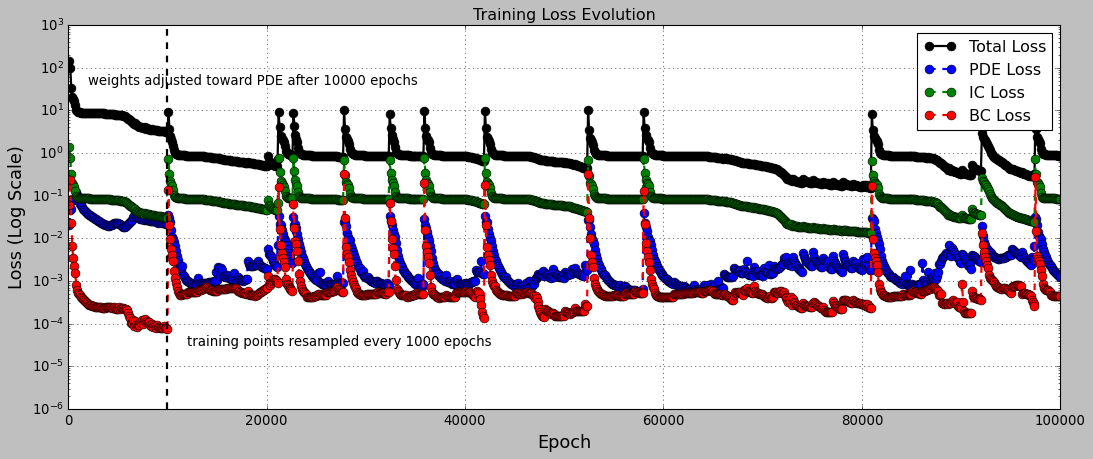

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the log file
log_df = pd.read_csv('training_log.csv')

# Plot the losses on a logarithmic scale
plt.style.use('classic')
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(log_df['Epoch'], log_df['Total_Loss'], label='Total Loss', lw=2, color='black', linestyle='-', marker='o', markersize=8)
ax.plot(log_df['Epoch'], log_df['PDE_Loss'], label='PDE Loss', lw=2, linestyle='--', marker='o', markersize=8)
ax.plot(log_df['Epoch'], log_df['IC_Loss'], label='IC Loss', lw=2, linestyle='--', marker='o', markersize=8)
ax.plot(log_df['Epoch'], log_df['BC_Loss'], label='BC Loss', lw=2, linestyle='--', marker='o', markersize=8)

ax.vlines(10000, 10**(-6), 10**3, colors='k', ls='--', lw=2)
ax.text(2000,40, 'weights adjusted toward PDE after 10000 epochs')
ax.text(12000,10**(-4.5), 'training points resampled every 1000 epochs')

ax.set_yscale('log')
ax.set_title('Training Loss Evolution')
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('Loss (Log Scale)', fontsize=16)
ax.legend()
ax.grid(True)#, which="both", ls="--")
plt.savefig('Loss_Evolution.png', bbox_inches='tight', dpi=1200)
plt.show()

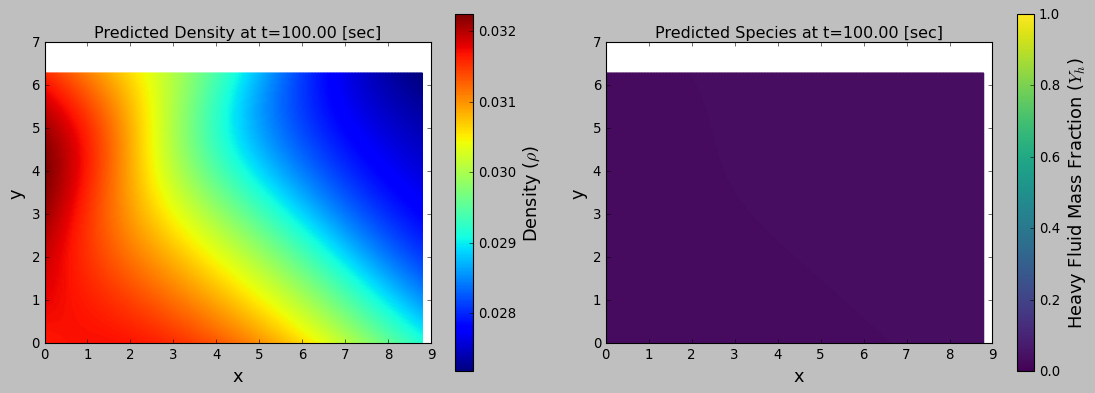

In [8]:
# --- Visualization ---
t_snap = t_max
nx, ny = Npts, Npts
x = torch.linspace(x_min, x_max, nx)
y = torch.linspace(y_min, y_max, ny)
X, Y = torch.meshgrid(x, y, indexing='ij')
T = torch.full_like(X, t_snap)

X_flat, Y_flat, T_flat = X.flatten()[:, None].to(device), Y.flatten()[:, None].to(device), T.flatten()[:, None].to(device)

with torch.no_grad():
    pred_flat = pinn(T_flat, X_flat, Y_flat)
    rho_pred, u_pred, v_pred, p_pred, Yh_pred = torch.split(pred_flat, 1, dim=1)

# Reshape for plotting
rho_grid = rho_pred.reshape(nx, ny).cpu().numpy()
Yh_grid = Yh_pred.reshape(nx, ny).cpu().numpy()
X_cpu, Y_cpu = X.numpy(), Y.numpy()

plt.style.use('classic')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# --- Plot Density ---
c1_plot = ax1.pcolormesh(X_cpu, Y_cpu, rho_grid, cmap='jet', shading='gouraud')
cbar1 = fig.colorbar(c1_plot, ax=ax1)
cbar1.set_label(r'Density ($\rho$)', fontsize=16)
cbar1.ax.tick_params(labelsize=12)

ax1.set_title(f'Predicted Density at t={t_snap:.2f} [sec]')
ax1.set_xlabel('x', fontsize=16)
ax1.set_ylabel('y', fontsize=16)
ax1.set_aspect('equal', 'box')

# --- Plot Species Fraction ---
c2_plot = ax2.pcolormesh(X_cpu, Y_cpu, Yh_grid, cmap='viridis', shading='gouraud', vmin=0, vmax=1)
cbar2 = fig.colorbar(c2_plot, ax=ax2)
cbar2.set_label('Heavy Fluid Mass Fraction ($Y_h$)', fontsize=16)
cbar2.ax.tick_params(labelsize=12)

ax2.set_title(f'Predicted Species at t={t_snap:.2f} [sec]')
ax2.set_xlabel('x', fontsize=16)
ax2.set_ylabel('y', fontsize=16)
ax2.set_aspect('equal', 'box')

fig.tight_layout()
plt.savefig('RTI_Compressible_PINN.png', bbox_inches='tight', dpi=1200)
plt.show()

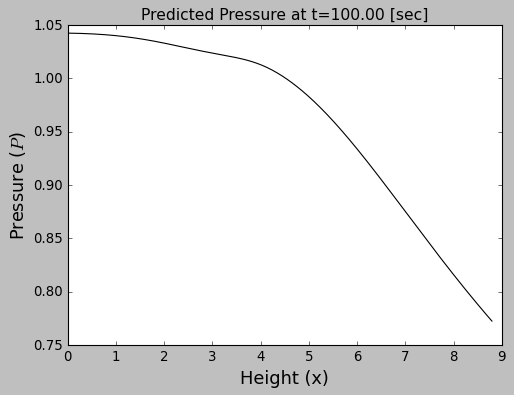

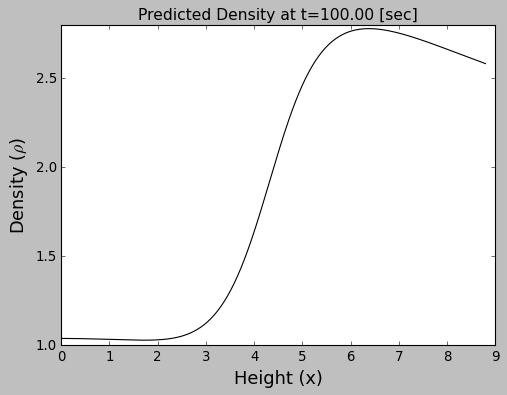

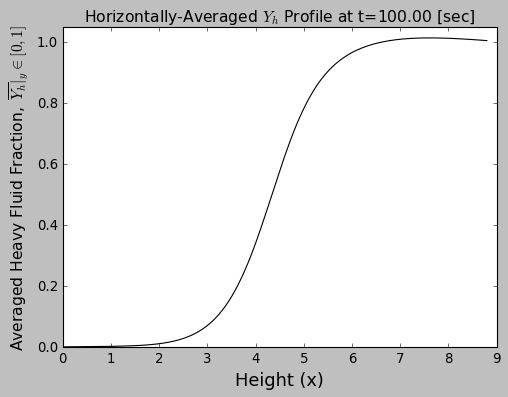

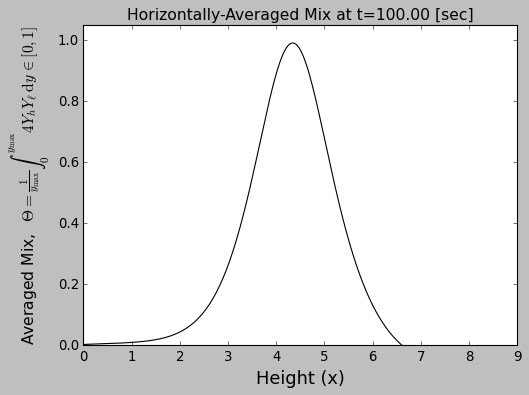

In [14]:
# --- Generate a single 2D grid for all calculations ---
x_2d = torch.linspace(x_min, x_max, nx, device=device)
y_2d = torch.linspace(y_min, y_max, ny, device=device)
X_2d, Y_2d = torch.meshgrid(x_2d, y_2d, indexing='ij')

# Flatten for the PINN
X_flat_2d = X_2d.flatten()[:, None]
Y_flat_2d = Y_2d.flatten()[:, None]
T_flat_2d = torch.full_like(X_flat_2d, t_snap)

# --- Make ONE prediction on the 2D grid ---
pinn.eval()
with torch.no_grad():
    # Predict all variables needed for the plots
    rho_pred_flat, _, _, p_pred_flat, Yh_pred_flat = torch.split(pinn(T_flat_2d, X_flat_2d, Y_flat_2d), 1, dim=1)

# --- Reshape all predictions back to 2D grids ---
rho_grid = rho_pred_flat.reshape(nx, ny)
p_grid = p_pred_flat.reshape(nx, ny)
Yh_grid = Yh_pred_flat.reshape(nx, ny)

# --- Extract Data for the 1D Slice Plots ---
y_slice_idx = ny // 2
x_plot_1d = x_2d.cpu().numpy()
p_plot_1d = p_grid[:, y_slice_idx].cpu().numpy()
rho_plot_1d = rho_grid[:, y_slice_idx].cpu().numpy()

# --- Calculate Data for the Horizontally-Averaged Plots ---
# Calculate Horizontally-Averaged Yh Profile
horizontally_averaged_yh = torch.mean(Yh_grid, axis=1).cpu().numpy()

# Calculate Horizontally-Averaged Mix Profile
mix_grid = 4.0 * Yh_grid * (1.0 - Yh_grid)
horizontally_averaged_mix = torch.mean(mix_grid, axis=1).cpu().numpy()

# --- Create the Individual 1D Profile Plots ---
plt.style.use('classic')

# --- Pressure Profile (1D Slice) ---
plt.figure(figsize=(7, 5))
plt.plot(x_plot_1d, p_plot_1d, color='k', linewidth=1)
plt.title(f'Predicted Pressure at t={t_snap:.2f} [sec]', fontsize=14)
plt.xlabel('Height (x)', fontsize=16)
plt.ylabel('Pressure ($P$)', fontsize=16)
plt.xlim(0, 9)
#plt.grid(True)
plt.savefig('RTI_Profile_Pressure.png', bbox_inches='tight', dpi=1200)
plt.show()

# --- Density Profile (1D Slice) ---
plt.figure(figsize=(7, 5))
plt.plot(x_plot_1d, rho_plot_1d, color='k', linewidth=1)
plt.title(f'Predicted Density at t={t_snap:.2f} [sec]', fontsize=14)
plt.xlabel('Height (x)', fontsize=16)
plt.ylabel(r'Density ($\rho$)', fontsize=16)
plt.xlim(0, 9)
#plt.grid(True)
plt.savefig('RTI_Profile_Density.png', bbox_inches='tight', dpi=1200)
plt.show()

# --- Horizontally-Averaged Yh Profile ---
plt.figure(figsize=(7, 5))
plt.plot(x_plot_1d, horizontally_averaged_yh, color='k', linewidth=1)
plt.title(f'Horizontally-Averaged $Y_h$ Profile at t={t_snap:.2f} [sec]', fontsize=14)
plt.xlabel('Height (x)', fontsize=16)
plt.ylabel(r'Averaged Heavy Fluid Fraction, $\, \overline{Y_h}|_y \in [0,1]$', fontsize=14)
plt.xlim(0, 9)
plt.ylim(0, 1.05) # Yh is between 0 and 1
#plt.grid(True)
plt.savefig('RTI_Profile_Avg_Yh.png', bbox_inches='tight', dpi=1200)
plt.show()

# --- Horizontally-Averaged Mix Profile ---
plt.figure(figsize=(7, 5))
plt.plot(x_plot_1d, horizontally_averaged_mix, color='k', linewidth=1)
plt.title(f'Horizontally-Averaged Mix at t={t_snap:.2f} [sec]', fontsize=14)
plt.xlabel('Height (x)', fontsize=16)
plt.ylabel(r'Averaged Mix,  $\, \Theta = \frac{1}{y_\mathrm{max}} \int_0^{y_\mathrm{max}} 4 Y_h Y_{\ell} \, \mathrm{d}y \, \in [0,1]$', fontsize=14)
plt.xlim(0, 9)
plt.ylim(0, 1.05)
#plt.grid(True)
plt.savefig('RTI_Profile_Avg_Mix.png', bbox_inches='tight', dpi=1200)
plt.show()

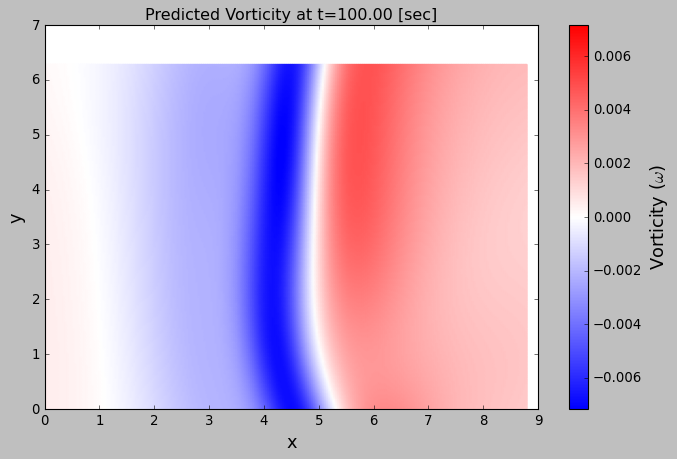

In [15]:
# Ensure the prediction grid requires gradients
X_flat.requires_grad = True
Y_flat.requires_grad = True

# Re-run the prediction with graph creation enabled
rho_pred, u_pred, v_pred, p_pred, Yh_pred = torch.split(pinn(T_flat, X_flat, Y_flat), 1, dim=1)

# Calculate vorticity = dv/dx - du/dy
dv_dx = torch.autograd.grad(v_pred, X_flat, grad_outputs=torch.ones_like(v_pred), create_graph=True)[0]
du_dy = torch.autograd.grad(u_pred, Y_flat, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
vorticity = dv_dx - du_dy

# Reshape for plotting
vorticity_grid = vorticity.reshape(nx, ny).cpu().detach().numpy()

# Create the plot
plt.style.use('classic')
fig, ax = plt.subplots(figsize=(10, 6))
# Use a diverging colormap like 'bwr' (blue-white-red) for vorticity
vmax = np.abs(vorticity_grid).max() # Symmetrize color bar
c = ax.pcolormesh(X_cpu, Y_cpu, vorticity_grid, cmap='bwr', shading='gouraud', vmin=-vmax, vmax=vmax)
cbar = fig.colorbar(c, ax=ax)
cbar.set_label(r'Vorticity ($\omega$)', fontsize=16)
cbar.ax.tick_params(labelsize=12)
ax.set_title(f'Predicted Vorticity at t={t_snap:.2f} [sec]')
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.set_aspect('equal', 'box')
plt.savefig('RTI_Vorticity.png', bbox_inches='tight', dpi=1200)
plt.show()

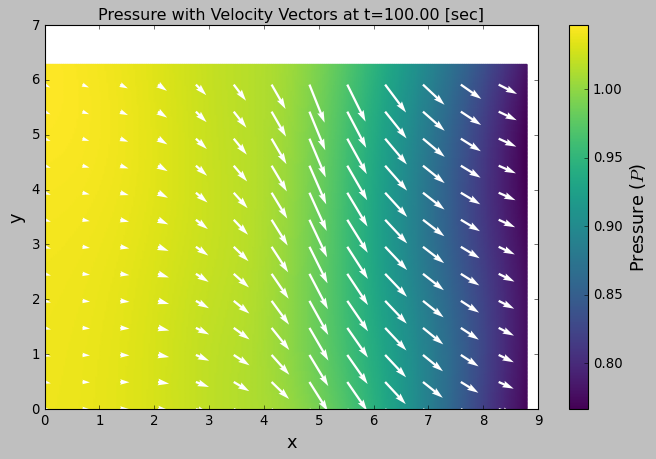

In [16]:
# Reshape predictions
u_grid = u_pred.reshape(nx, ny).cpu().detach().numpy()
v_grid = v_pred.reshape(nx, ny).cpu().detach().numpy()
p_grid = p_pred.reshape(nx, ny).cpu().detach().numpy()

# Downsample the grid for the quiver plot to avoid clutter
skip = 20 # Plot one arrow every 20 grid points

# Create the plot
plt.style.use('classic')
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the pressure field as the background
c = ax.pcolormesh(X_cpu, Y_cpu, p_grid, cmap='viridis', shading='gouraud')
cbar = fig.colorbar(c, ax=ax)
cbar.set_label(r'Pressure ($P$)', fontsize=16)
cbar.ax.tick_params(labelsize=12)

# Overlay the quiver plot of velocity vectors
ax.quiver(X_cpu[::skip, ::skip], Y_cpu[::skip, ::skip], 
            u_grid[::skip, ::skip], v_grid[::skip, ::skip], 
            color='white', scale=None) # Adjust scale as needed

ax.set_title(f'Pressure with Velocity Vectors at t={t_snap:.2f} [sec]')
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.set_aspect('equal', 'box')
plt.savefig('RTI_Quiver.png', bbox_inches='tight', dpi=1200)
plt.show()

In [10]:
time_steps = np.linspace(t_min, t_max, 50)
mixing_widths = []

for t_val in time_steps:
    # Generate a prediction grid for this time step 't_val'
    T_snap = torch.full_like(X, t_val)
    T_flat = T_snap.flatten()[:, None].to(device)
    
    with torch.no_grad():
        pred_flat = pinn(T_flat, X_flat, Y_flat)
        _, _, _, _, Yh_pred = torch.split(pred_flat, 1, dim=1)
    
    Yh_grid = Yh_pred.reshape(nx, ny)
    
    # Calculate the horizontally-averaged profile of Yh
    avg_Yh_profile = torch.mean(Yh_grid, axis=1).cpu().numpy()
    x_coords = X[:, 0].cpu().numpy()

    # Find the x-positions where avg_Yh is ~0.01 and ~0.99
    try:
        x_01 = x_coords[np.where(avg_Yh_profile > 0.01)[0][0]]
        x_99 = x_coords[np.where(avg_Yh_profile > 0.99)[0][0]]
        mixing_widths.append(x_99 - x_01)
    except IndexError:
        mixing_widths.append(0) # In case the interface hasn't spread enough


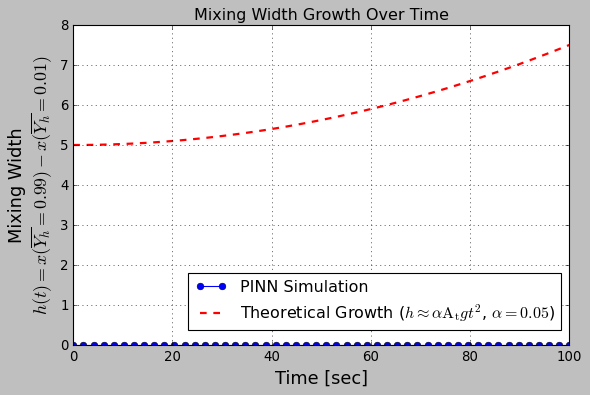

In [11]:
# --- Define parameters and calculate the theoretical growth curve ---
g = 0.01
At = 0.5
alpha = 0.05  # Typical non-dimensional growth rate for 2D RTI

# Calculate width for each time step using the formula
W_theoretical = alpha * At * g * (time_steps**2)

# Plot the result
plt.style.use('classic')
plt.figure(figsize=(8, 5))
# Plot the data from the PINN simulation
plt.plot(time_steps, mixing_widths, marker='o', linestyle='-', label='PINN Simulation')
# Plot the theoretical trend line
plt.plot(time_steps, W_theoretical+5, color='red', linestyle='--', linewidth=2, label=f'Theoretical Growth ($h \\approx \\alpha \mathrm{{A_t}} g t^2$, $\\alpha={alpha}$)')

plt.title('Mixing Width Growth Over Time')
plt.xlabel('Time [sec]', fontsize=16)
plt.ylabel('Mixing Width\n' r'$h(t) = x(\overline{Y_h} = 0.99) - x(\overline{Y_h} = 0.01)$', fontsize=16)
plt.grid(True)
plt.legend(bbox_to_anchor=[1.0, 0.25])
plt.savefig('RTI_Mixing_Height.png', bbox_inches='tight', dpi=1200)
plt.show()

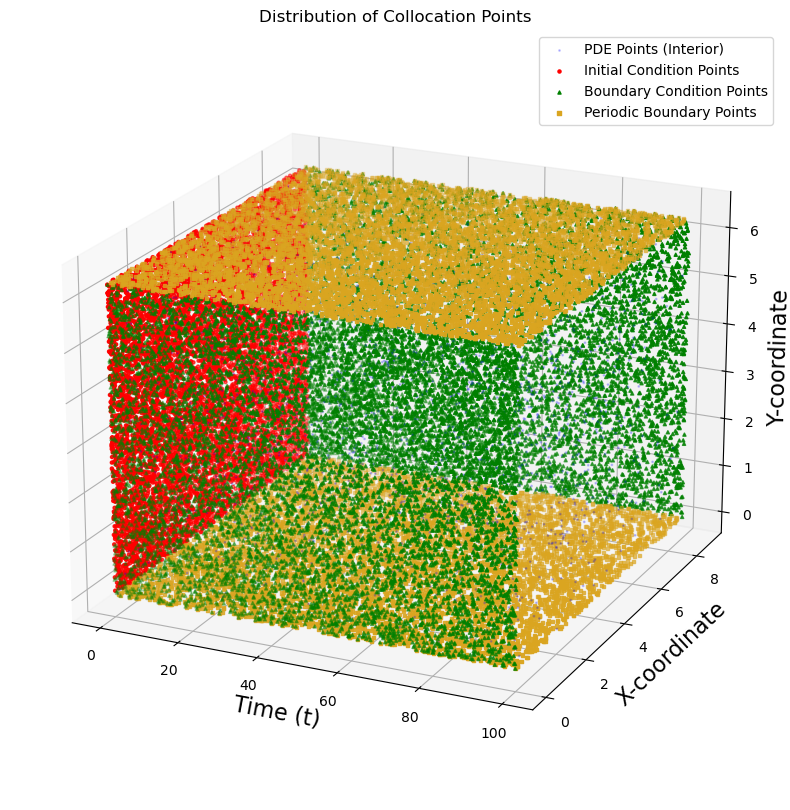

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- Run the sampling code to have these variables ---
# t_pde, x_pde, y_pde
# t_ic, x_ic, y_ic
# t_bc, x_bc_y_periodic, y_bc_x_walls

# --- Convert tensors to numpy for plotting ---
# Plot a subset of the PDE points
subset_size = 2000

# Added .detach() before .numpy()
pde_points_t = t_pde.cpu().detach().numpy()[:subset_size]
pde_points_x = x_pde.cpu().detach().numpy()[:subset_size]
pde_points_y = y_pde.cpu().detach().numpy()[:subset_size]

# Do the same for all tensors, even if they don't require grad
ic_points_t = t_ic.cpu().detach().numpy()
ic_points_x = x_ic.cpu().detach().numpy()
ic_points_y = y_ic.cpu().detach().numpy()

bc_points_t = t_bc.cpu().detach().numpy()
bc_points_x_periodic = x_bc_y_periodic.cpu().detach().numpy()
bc_points_y_walls = y_bc_x_walls.cpu().detach().numpy()


# --- Create the 3D Scatter Plot ---
plt.style.use('default')
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot PDE collocation points (in the volume)
ax.scatter(pde_points_t, pde_points_x, pde_points_y, s=1, c='blue', alpha=0.2, label='PDE Points (Interior)')

# Plot Initial Condition points (on the t=0 plane)
ax.scatter(ic_points_t, ic_points_x, ic_points_y, s=5, c='red', marker='o', label='Initial Condition Points')

# Plot Boundary Condition points (on the faces)
# X-walls
ax.scatter(bc_points_t, np.full_like(bc_points_t, x_min), bc_points_y_walls, s=5, c='green', marker='^', label='Boundary Condition Points')
ax.scatter(bc_points_t, np.full_like(bc_points_t, x_max), bc_points_y_walls, s=5, c='green', marker='^')
# Y-periodic
ax.scatter(bc_points_t, bc_points_x_periodic, np.full_like(bc_points_t, y_min), s=5, c='goldenrod', marker='s', label='Periodic Boundary Points')
ax.scatter(bc_points_t, bc_points_x_periodic, np.full_like(bc_points_t, y_max), s=5, c='goldenrod', marker='s')

ax.set_xlabel('Time (t)', fontsize=16)
ax.set_ylabel('X-coordinate', fontsize=16)
ax.set_zlabel('Y-coordinate', fontsize=16)
ax.set_title('Distribution of Collocation Points')
ax.view_init(elev=20., azim=-65) # Adjust viewing angle
ax.legend()
plt.savefig('collocation_points.png', bbox_inches='tight', dpi=1200)
plt.show()

In [ ]:
!conda install pillow

In [20]:
import matplotlib.animation as animation

# --- Setup for Animation ---
fig, ax = plt.subplots(figsize=(10, 6))
plt.style.use('classic')

num_frames = 100  # Number of frames in the animation
time_points = np.linspace(t_min, t_max, num_frames)

# Create the plotting grid
x = torch.linspace(x_min, x_max, nx)
y = torch.linspace(y_min, y_max, ny)
X, Y = torch.meshgrid(x, y, indexing='ij')
X_flat, Y_flat = X.flatten()[:, None].to(device), Y.flatten()[:, None].to(device)

# Initial plot object (will be updated each frame)
with torch.no_grad():
    T_init = torch.full_like(X_flat, t_min)
    rho_init, _, _, _, _ = torch.split(pinn(T_init, X_flat, Y_flat), 1, dim=1)
    rho_grid_init = rho_init.reshape(nx, ny).cpu().numpy()

im = ax.pcolormesh(X.numpy(), Y.numpy(), rho_grid_init, cmap='jet', shading='gouraud')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'Density ($\rho$)', fontsize=16)
cbar.ax.tick_params(labelsize=12)
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_aspect('equal', 'box')

# --- Animation Update Function ---
def update(frame):
    t = time_points[frame]
    T_snap = torch.full_like(X_flat, t)
    
    with torch.no_grad():
        pred_flat = pinn(T_snap, X_flat, Y_flat)
        rho_pred, _, _, _, _ = torch.split(pred_flat, 1, dim=1)
    
    rho_grid = rho_pred.reshape(nx, ny).cpu().numpy()
    
    # Update the plot data and title
    im.set_array(rho_grid.ravel())
    ax.set_title(f'Predicted Density at t={t:.2f} [sec]')
    return im,

# --- Create and Save Animation ---
print("Creating animation... this may take a few minutes.")
ani = animation.FuncAnimation(fig, update, frames=num_frames, blit=True)
ani.save('rti_animation.gif', writer='pillow', fps=10) # fps = frames per second
print("Animation saved as rti_animation.gif")
plt.close() # Close the plot window

Creating animation... this may take a few minutes.
Animation saved as rti_animation.gif


In [ ]:
!pip install torchinfo

In [21]:
from torchinfo import summary

# Assumes 'pinn' model object and 'device' already exist

# 1. Create a list of dummy tensors, one for each input argument (t, x, y)
batch_size = 1 # The batch size can be anything for the summary
input_data = [
    torch.randn(batch_size, 1).to(device), # Dummy 't' tensor
    torch.randn(batch_size, 1).to(device), # Dummy 'x' tensor
    torch.randn(batch_size, 1).to(device)  # Dummy 'y' tensor
]

# 2. Pass this list using the 'input_data' argument
summary(pinn, input_data=input_data)

Layer (type:depth-idx)                   Output Shape              Param #
PINN                                     [1, 5]                    --
├─ModuleList: 1-17                       --                        (recursive)
│    └─Linear: 2-1                       [1, 128]                  512
├─Tanh: 1-2                              [1, 128]                  --
├─ModuleList: 1-17                       --                        (recursive)
│    └─Linear: 2-2                       [1, 128]                  16,512
├─Tanh: 1-4                              [1, 128]                  --
├─ModuleList: 1-17                       --                        (recursive)
│    └─Linear: 2-3                       [1, 128]                  16,512
├─Tanh: 1-6                              [1, 128]                  --
├─ModuleList: 1-17                       --                        (recursive)
│    └─Linear: 2-4                       [1, 128]                  16,512
├─Tanh: 1-8                         

In [ ]:
!pip install torchviz

In [22]:
from torchviz import make_dot

# Assumes 'pinn' model object already exists
# Create a dummy input tensor
dummy_input = torch.randn(1, 3, requires_grad=True).to(device)

# Perform a forward pass
y = pinn(*torch.split(dummy_input, 1, dim=1))

# Create the graph
# Note: For complex models, this graph can be huge.
graph = make_dot(y.mean(), params=dict(pinn.named_parameters()))

# Save the graph to a file (e.g., PDF or PNG)
graph.render("pinn_structure", format="png")
print("Saved network graph to pinn_structure.png")

Saved network graph to pinn_structure.png


## 6. Viscous Training (Navier-Stokes)
A secondary training configuration that includes viscous stress terms $\boldsymbol{\tau}$ and heat flux $\mathbf{q}$.
* **$\mathrm{Re}$ & $\mathrm{Pr}$:** Reynolds and Prandtl numbers are defined here to set dynamic viscosity $\mu$ and thermal conductivity $\kappa$.
* **Note:** This increases computational cost significantly due to the calculation of second-order derivatives (Hessians).

In [ ]:
# Main training script
if __name__ == '__main__':
    # --- Physical and Domain Parameters from pyranda script ---
    gx = -0.01
    mwH = 3.0
    mwL = 1.0
    Runiv = 1.0
    CVh, CPh = 1.0, 1.4
    CVl, CPl = 1.0, 1.4
    p0 = 1.0
    T0 = 1.0

    # Viscosity and thermal conductivity parameters
    Re = 1000.0  # Reynolds Number
    Pr = 0.71   # Prandtl Number (for air-like gas)
    
    # Domain
    t_min, t_max = 0.0, 100.0
    x_min, x_max = 0.0, 3.0 * np.pi
    y_min, y_max = 0.0, 2.0 * np.pi
    Npts = 256

    # --- Calculate characteristic scales and transport properties ---
    L0 = x_max - x_min
    rho0 = 1.0 # Characteristic density
    u0 = 1.0   # Characteristic velocity
    mu = (rho0 * u0 * L0) / Re
    # For simplicity, assume kappa is constant based on characteristic cp
    cp0 = 1.4 
    kappa = (mu * cp0) / Pr
    print(f"Reynolds Number: {Re}, Prandtl Number: {Pr}")
    print(f"Calculated mu: {mu:.4e}, kappa: {kappa:.4e}")
    
    # --- Network, Training, and Loss Weighting Setup ---
    # Input: 3 (t,x,y), Output: 5 (rho, u, v, p, Yh)
    layers = [3] + [128] * 8 + [5]
    pinn = PINN(layers).to(device)

    optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.9)
    
    # Loss weights
    w_pde = 1.0
    w_ic = 100.0
    w_bc = 100.0
    
    # --- Generate Training Points (Collocation Points) ---
    N_pde = 25000
    N_ic = 10000
    N_bc = 7500
    num_epochs = 30000    
      
    # For PDE Loss
    sampler = qmc.LatinHypercube(d=3, seed=123)
    pde_sample = sampler.random(n=N_pde)
    t_pde = torch.tensor(t_min + (t_max - t_min) * pde_sample[:, 0], dtype=torch.float32).view(-1, 1).to(device)
    x_pde = torch.tensor(x_min + (x_max - x_min) * pde_sample[:, 1], dtype=torch.float32).view(-1, 1).to(device)
    y_pde = torch.tensor(y_min + (y_max - y_min) * pde_sample[:, 2], dtype=torch.float32).view(-1, 1).to(device)
    
    # For Initial Condition Loss
    ic_sampler = qmc.LatinHypercube(d=2, seed=456)
    ic_sample = ic_sampler.random(n=N_ic)
    x_ic = torch.tensor(x_min + (x_max - x_min) * ic_sample[:, 0], dtype=torch.float32).view(-1, 1).to(device)
    y_ic = torch.tensor(y_min + (y_max - y_min) * ic_sample[:, 1], dtype=torch.float32).view(-1, 1).to(device)
    t_ic = torch.zeros_like(x_ic).to(device)
    
    # For Boundary Condition Loss
    bc_sampler = qmc.LatinHypercube(d=2, seed=789)
    bc_sample = bc_sampler.random(n=N_bc)
    t_bc = torch.tensor(t_min + (t_max - t_min) * bc_sample[:, 0], dtype=torch.float32).view(-1, 1).to(device)
    # Points for x-walls
    y_bc_x_walls = torch.tensor(y_min + (y_max - y_min) * bc_sample[:, 1], dtype=torch.float32).view(-1, 1).to(device)
    # Points for y-periodic
    x_bc_y_periodic = torch.tensor(x_min + (x_max - x_min) * bc_sample[:, 1], dtype=torch.float32).view(-1, 1).to(device)

    # --- Define Initial Conditions ---
    delta_interface = 2.0 * np.pi / Npts * 2.0
    offset_ic = 1.4 * np.pi + 0.5 * torch.sin(2 * y_ic)
    Yh_ic_true = 0.5 * (1.0 + torch.tanh((x_ic - offset_ic) / delta_interface))
    
    R_h = Runiv / mwH
    R_l = Runiv / mwL
    A = gx * (R_h + R_l) / (2.0 * T0 * R_l * R_h)
    B = gx * delta_interface * (R_l - R_h) / (2.0 * T0 * R_l * R_h)
    p_ic_true = p0 * torch.exp(A * (x_ic-offset_ic)) * (torch.cosh((x_ic-offset_ic)/delta_interface))**B
    
    R_ic = R_h * Yh_ic_true + R_l * (1.0 - Yh_ic_true)
    rho_ic_true = p_ic_true / (R_ic * T0)
    u_ic_true = torch.zeros_like(x_ic)
    v_ic_true = torch.zeros_like(x_ic)

    # --- Progress Bar and Logging Setup ---
    # Create directory for checkpoints
    checkpoint_dir = 'checkpoints'
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Setup for logging loss to a file
    log_file_path = 'training_log.csv'
    log_file = open(log_file_path, 'w')
    log_file.write('Epoch,Total_Loss,PDE_Loss,IC_Loss,BC_Loss,Elapsed_Time\n')
    
    best_loss = float('inf')
    
    # Wrap the training loop with tqdm
    pbar = tqdm(range(start_epoch, num_epochs), desc=f"Training Viscous (Resumed from {start_epoch})")
    
    # --- Training Loop ---
    start_time = time.time()
    for epoch in pbar:
        optimizer.zero_grad()
        
        # --- FULL PDE LOSS CALCULATION ---
        t_pde.requires_grad = True
        x_pde.requires_grad = True
        y_pde.requires_grad = True

        # Get primitive variables from network
        rho, u, v, p, Yh = torch.split(pinn(t_pde, x_pde, y_pde), 1, dim=1)
        Yl = 1.0 - Yh
        
        # Calculate conserved and other variables
        rhou = rho * u
        rhov = rho * v
        rhoYh = rho * Yh
        R = (Runiv / mwH) * Yh + (Runiv / mwL) * Yl
        T = p / (rho * R + 1e-8)
        cp = CPh * Yh + CPl * Yl
        cv = CVh * Yh + CVl * Yl
        gamma = cp / (cv + 1e-8)
        Et = p / (gamma - 1.0 + 1e-8) + 0.5 * rho * (u**2 + v**2)

        # --- Calculate viscous stresses and heat flux ---
        # First, get all required first-order gradients
        u_grads = torch.autograd.grad(u, [x_pde, y_pde], grad_outputs=torch.ones_like(u), create_graph=True)
        u_x, u_y = u_grads[0], u_grads[1]
        v_grads = torch.autograd.grad(v, [x_pde, y_pde], grad_outputs=torch.ones_like(v), create_graph=True)
        v_x, v_y = v_grads[0], v_grads[1]
        T_grads = torch.autograd.grad(T, [x_pde, y_pde], grad_outputs=torch.ones_like(T), create_graph=True)
        T_x, T_y = T_grads[0], T_grads[1]
        
        # Viscous Stresses
        tau_xx = (2./3.) * mu * (2 * u_x - v_y)
        tau_yy = (2./3.) * mu * (2 * v_y - u_x)
        tau_xy = mu * (u_y + v_x)
        
        # Heat Flux
        q_x = -kappa * T_x
        q_y = -kappa * T_y

        # --- Calculate residuals for the 5 conservation laws ---
        # Inviscid fluxes and their derivatives
        # Mass:
        rho_t = torch.autograd.grad(rho, t_pde, torch.ones_like(rho), create_graph=True)[0]
        rhou_x = torch.autograd.grad(rhou, x_pde, torch.ones_like(rhou), create_graph=True)[0]
        rhov_y = torch.autograd.grad(rhov, y_pde, torch.ones_like(rhov), create_graph=True)[0]
        f_mass = rho_t + rhou_x + rhov_y
        
        # Species:
        rhoYh_t = torch.autograd.grad(rhoYh, t_pde, torch.ones_like(rhoYh), create_graph=True)[0]
        rhoYhu_x = torch.autograd.grad(rhoYh * u, x_pde, torch.ones_like(u), create_graph=True)[0]
        rhoYhv_y = torch.autograd.grad(rhoYh * v, y_pde, torch.ones_like(v), create_graph=True)[0]
        f_species = rhoYh_t + rhoYhu_x + rhoYhv_y # Note: No species diffusion in this model
        
        # X-Momentum: d(rhou)/dt + d(rhou*u+p)/dx + d(rhov*u)/dy = d(tau_xx)/dx + d(tau_xy)/dy + rho*gx
        rhou_t = torch.autograd.grad(rhou, t_pde, torch.ones_like(rhou), create_graph=True)[0]
        rhouu_p_x = torch.autograd.grad(rhou * u + p, x_pde, torch.ones_like(p), create_graph=True)[0]
        rhovu_y = torch.autograd.grad(rhov * u, y_pde, torch.ones_like(u), create_graph=True)[0]
        tau_xx_x = torch.autograd.grad(tau_xx, x_pde, torch.ones_like(tau_xx), create_graph=True)[0]
        tau_xy_y = torch.autograd.grad(tau_xy, y_pde, torch.ones_like(tau_xy), create_graph=True)[0]
        f_mom_x = (rhou_t + rhouu_p_x + rhovu_y) - (tau_xx_x + tau_xy_y) - (rho * gx)
        
        # Y-Momentum: d(rhov)/dt + d(rhou*v)/dx + d(rhov*v+p)/dy = d(tau_xy)/dx + d(tau_yy)/dy
        rhov_t = torch.autograd.grad(rhov, t_pde, torch.ones_like(rhov), create_graph=True)[0]
        rhouv_x = torch.autograd.grad(rhou * v, x_pde, torch.ones_like(v), create_graph=True)[0]
        rhovv_p_y = torch.autograd.grad(rhov * v + p, y_pde, torch.ones_like(p), create_graph=True)[0]
        tau_xy_x = torch.autograd.grad(tau_xy, x_pde, torch.ones_like(tau_xy), create_graph=True)[0]
        tau_yy_y = torch.autograd.grad(tau_yy, y_pde, torch.ones_like(tau_yy), create_graph=True)[0]
        f_mom_y = (rhov_t + rhouv_x + rhovv_p_y) - (tau_xy_x + tau_yy_y)
        
        # Energy: d(Et)/dt + d((Et+p)u)/dx + d((Et+p)v)/dy = d(u*tau_xx+v*tau_xy - qx)/dx + d(u*tau_xy+v*tau_yy - qy)/dy + rho*gx*u
        Et_t = torch.autograd.grad(Et, t_pde, torch.ones_like(Et), create_graph=True)[0]
        Et_p_u_x = torch.autograd.grad((Et + p) * u, x_pde, torch.ones_like(u), create_graph=True)[0]
        Et_p_v_y = torch.autograd.grad((Et + p) * v, y_pde, torch.ones_like(v), create_graph=True)[0]
        visc_heat_x = torch.autograd.grad(u * tau_xx + v * tau_xy + q_x, x_pde, torch.ones_like(u), create_graph=True)[0]
        visc_heat_y = torch.autograd.grad(u * tau_xy + v * tau_yy + q_y, y_pde, torch.ones_like(v), create_graph=True)[0]
        f_energy = (Et_t + Et_p_u_x + Et_p_v_y) - (visc_heat_x + visc_heat_y) - (rho * gx * u)
        
        loss_pde = torch.mean(f_mass**2) + torch.mean(f_species**2) + \
                   torch.mean(f_mom_x**2) + torch.mean(f_mom_y**2) + \
                   torch.mean(f_energy**2)

        # --- INITIAL CONDITION LOSS ---
        rho_ic, u_ic, v_ic, p_ic, Yh_ic = torch.split(pinn(t_ic, x_ic, y_ic), 1, dim=1)
        
        loss_ic = torch.mean((rho_ic - rho_ic_true)**2) + \
                  torch.mean((u_ic - u_ic_true)**2) + \
                  torch.mean((v_ic - v_ic_true)**2) + \
                  torch.mean((p_ic - p_ic_true)**2) + \
                  torch.mean((Yh_ic - Yh_ic_true)**2)
        
        # --- BOUNDARY CONDITION LOSS ---
        # Periodic in Y
        y_min_bc = torch.full_like(x_bc_y_periodic, y_min)
        y_max_bc = torch.full_like(x_bc_y_periodic, y_max)
        out_ymin = pinn(t_bc, x_bc_y_periodic, y_min_bc)
        out_ymax = pinn(t_bc, x_bc_y_periodic, y_max_bc)
        loss_bc_y_periodic = torch.mean((out_ymin - out_ymax)**2)

        # Fixed Walls in X (left wall: x=x_min)
        x_min_bc = torch.full_like(y_bc_x_walls, x_min)
        rho_xmin, u_xmin, v_xmin, p_xmin, Yh_xmin = torch.split(pinn(t_bc, x_min_bc, y_bc_x_walls), 1, dim=1)
        loss_bc_xmin = torch.mean(u_xmin**2) + torch.mean(v_xmin**2) + torch.mean(Yh_xmin**2)

        # Fixed Walls in X (right wall: x=x_max)
        x_max_bc = torch.full_like(y_bc_x_walls, x_max)
        rho_xmax, u_xmax, v_xmax, p_xmax, Yh_xmax = torch.split(pinn(t_bc, x_max_bc, y_bc_x_walls), 1, dim=1)
        loss_bc_xmax = torch.mean(u_xmax**2) + torch.mean(v_xmax**2) + torch.mean((Yh_xmax - 1.0)**2)
        
        loss_bc = loss_bc_y_periodic + loss_bc_xmin + loss_bc_xmax

        # --- TOTAL LOSS AND BACKPROPAGATION ---
        total_loss = w_pde * loss_pde + w_ic * loss_ic + w_bc * loss_bc
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        
        # --- Monitoring, Logging, and Checkpointing ---
        if (epoch + 1) % 100 == 0:
            elapsed_time = time.time() - start_time
            print(f'Epoch {epoch:5d}, Loss: {total_loss.item():.3e}, PDE: {loss_pde.item():.3e}, IC: {loss_ic.item():.3e}, BC: {loss_bc.item():.3e}, LR: {scheduler.get_last_lr()[0]:.3e}, Time: {elapsed_time:.1f}s')
            
            # Update the tqdm progress bar with the latest loss
            pbar.set_postfix({
                'Loss': f'{total_loss.item():.3e}',
                'PDE': f'{loss_pde.item():.3e}',
                'IC': f'{loss_ic.item():.3e}',
                'BC': f'{loss_bc.item():.3e}'
            })
            
            # Log to CSV file
            log_file.write(f'{epoch+1},{total_loss.item()},{loss_pde.item()},{loss_ic.item()},{loss_bc.item()},{elapsed_time:.2f}\n')
            log_file.flush() # Ensure it is written to disk immediately
            
            # Save the latest checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': pinn.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': total_loss.item(),
            }, os.path.join(checkpoint_dir, 'latest_checkpoint.pth'))
            
            # Save the best model if loss has improved
            if total_loss.item() < best_loss:
                best_loss = total_loss.item()
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': pinn.state_dict(),
                    'loss': best_loss,
                }, os.path.join(checkpoint_dir, 'best_model.pth'))
                
            start_time = time.time() # Reset timer for next interval

    # --- Finalization ---
    log_file.close()
    pbar.close()
    print("Training finished.")